In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
def particulas(lienzo, n_circles):
    '''
    Esta funcion dibuja circulitos al azar en un lienzo (matriz de ceros)
    el lienzo debe ser un array de numpy
    '''
    radio_minimo = 4
    radio_maximo = 10
    rng = np.random.default_rng()
    nx = lienzo.shape[0]
    ny = lienzo.shape[1]
    # para evitar superposicion agregamos los circulos 1 a 1
    # el primero
    x_cen = rng.integers(radio_maximo, nx-radio_maximo)
    y_cen = rng.integers(radio_maximo, ny-radio_maximo)
    radii = [rng.integers(radio_minimo,radio_maximo)]
    pos = [np.array([x_cen, y_cen])]
    # el resto
    for i in range(1, n_circles):
        done = True
        while done:
            x_cen = rng.integers(radio_maximo, nx-radio_maximo)
            y_cen = rng.integers(radio_maximo, ny-radio_maximo)
            radio = rng.integers(radio_minimo,radio_maximo)
            for j in range(len(pos)):
                dist = np.sqrt((x_cen -pos[j][0])**2 + (y_cen -pos[j][1])**2)
                if dist < (radii[j] + radio ):
                    break
                elif j == len(pos)-1:
                    radii.append(radio)
                    pos.append(np.array([x_cen, y_cen]))
                    done = False
                    
    # dibujamos en el lienzo
    
    for c in range(n_circles):
        for i in range(nx):
            for j in range(ny):
                if ((i-pos[c][0])**2 + (j-pos[c][1])**2 < radii[c]**2):
                    lienzo[i,j] = 1

    return lienzo


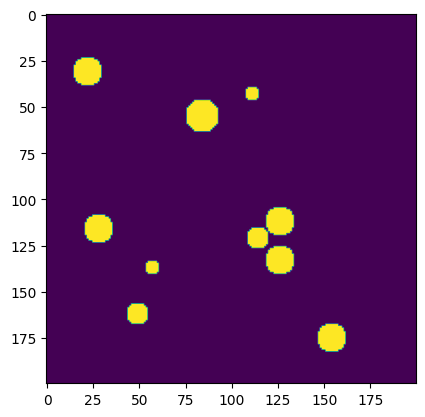

In [3]:
plt.imshow(particulas(np.zeros(shape=(200,200)), 10))

In [13]:
class DataImgs(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.nx = 200
        self.ny = 200
        self.data = np.array([particulas(np.zeros(shape=(self.nx,self.ny)), 10) for i in range(100)])

        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx].reshape(1,self.nx, self.ny)).float()

In [14]:
dataset = DataImgs()
dataloader = torch.utils.data.DataLoader(dataset, batch_size= 32, num_workers=3)

In [17]:

class Reshape(torch.nn.Module):
    def __init__(self, *args) -> None:
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Trim(torch.nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :100, :100]

class InitPool(torch.nn.Module):
    def __init__(self, *args) -> None:
        super().__init__()
        self.pool = torch.nn.AvgPool2d(kernel_size= (4,4))

    def forward(self, x):
        return self.pool(x)
    
class CNN_Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        leak = 2
        dr = 0.25
        self.encoder = torch.nn.Sequential(
                                torch.nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3),stride=(2,2), padding=1),
                                torch.nn.Dropout(dr),
                                torch.nn.ELU(leak),
                                torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),stride=(2,2), padding=1),
                                torch.nn.Dropout(dr),
                                torch.nn.ELU(leak),
                                torch.nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=(2,2), padding=1),
                                torch.nn.Dropout(dr),
                                torch.nn.ELU(leak),
                                torch.nn.Flatten(start_dim=1),
                                torch.nn.Linear(in_features=64*12*12,out_features=5),
                                # torch.nn.Tanh()
                                )

        self.decoder = torch.nn.Sequential(
                                torch.nn.Linear(in_features=5, out_features=64*12*12),
                                Reshape(-1,64,12,12),

                                torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1),
                                torch.nn.ELU(leak),
                                torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1),
                                torch.nn.ELU(leak),
                                torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(3,3), stride=(2,2), padding=1, output_padding=1),
                                torch.nn.ELU(leak),
                                Trim(),
                                torch.nn.Sigmoid(),
                                )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
cnn_model = CNN_Autoencoder()
cnn_model(next(iter(dataloader)))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x40000 and 9216x5)